In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
def find_txt_files(directory):
    # List to hold the names of .txt files
    txt_files = []

    # Loop through the files and directories in 'directory'
    for filename in os.listdir(directory):
        # Check if the filename ends with .txt
        if filename.endswith('.txt'):
            txt_files.append(filename)
    
    return txt_files

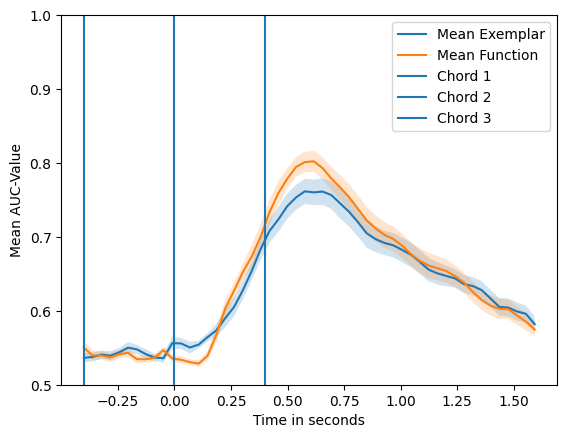

In [5]:
# Step and window size used for generating data
step = 5
window = 13

# Directory where the files are stored
data_dir = "./data"
file_paths = find_txt_files(data_dir)

file_paths = file_paths[:-1]

# List to store data from all subjects
all_roc_exemplar = []
all_roc_function = []

bad_subjects = ["040"]


# Process each file
for file_name in file_paths:
    if not any(substring in file_name for substring in bad_subjects):

        file_path = data_dir + "/" + file_name
        if os.path.exists(file_path):
            # Read the data from the file
            data = np.loadtxt(file_path)
            
            # Append the data to the lists
            all_roc_exemplar.append(abs(np.array(data[:, 0]) - 0.5) + 0.5)
            all_roc_function.append(abs(np.array(data[:, 1]) - 0.5) + 0.5)

            # exemplar = data[:, 0]
            # function = data[:, 1]
            # exemplar[exemplar < 0.5] = 0.5
            # function[function < 0.5] = 0.5

            # all_roc_exemplar.append(exemplar)
            # all_roc_function.append(function)




# Convert lists to NumPy arrays for efficient computation
all_roc_exemplar = np.array(all_roc_exemplar)
all_roc_function = np.array(all_roc_function)

# Compute the mean values using NumPy
mean_roc_exemplar = np.mean(all_roc_exemplar, axis=0)
mean_roc_function = np.mean(all_roc_function, axis=0)

std_roc_exemplar = np.std(all_roc_exemplar, axis=0) / np.sqrt(len(all_roc_exemplar))
std_roc_function = np.std(all_roc_function, axis=0) / np.sqrt(len(all_roc_function))

# Generate the time vector
time = [i * step / 128 - 0.4 for i in range(len(mean_roc_exemplar))]

# Plotting
plt.plot(time, mean_roc_exemplar, label="Mean Exemplar")
plt.fill_between(time, mean_roc_exemplar - std_roc_exemplar, mean_roc_exemplar + std_roc_exemplar, alpha=0.2)

plt.plot(time, mean_roc_function, label="Mean Function")
plt.fill_between(time, mean_roc_function - std_roc_function, mean_roc_function + std_roc_function, alpha=0.2)

plt.axvline(-0.4, label="Chord 1")
plt.axvline(0, label="Chord 2")
plt.axvline(0.4, label="Chord 3")
plt.ylim((0.5, 1))
plt.ylabel("Mean AUC-Value")
plt.xlabel("Time in seconds")
plt.legend()
plt.show()

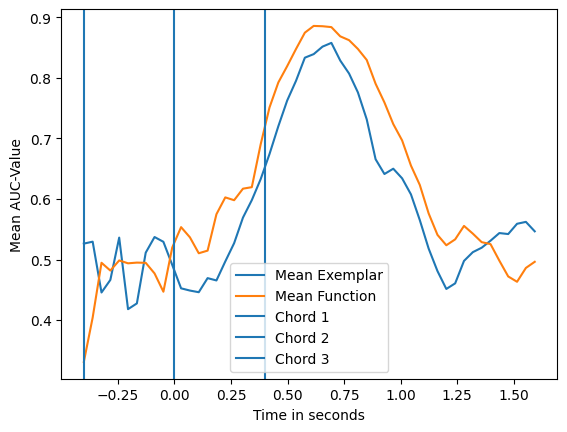

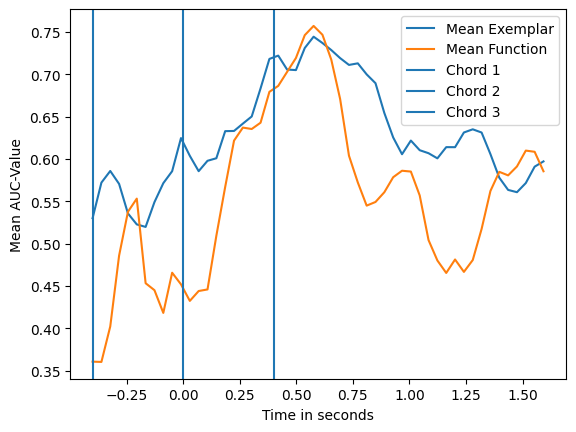

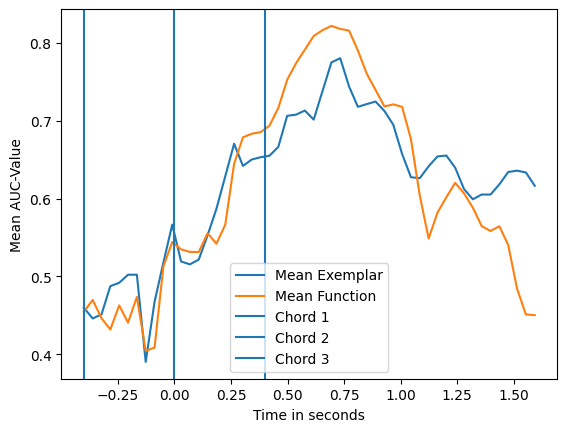

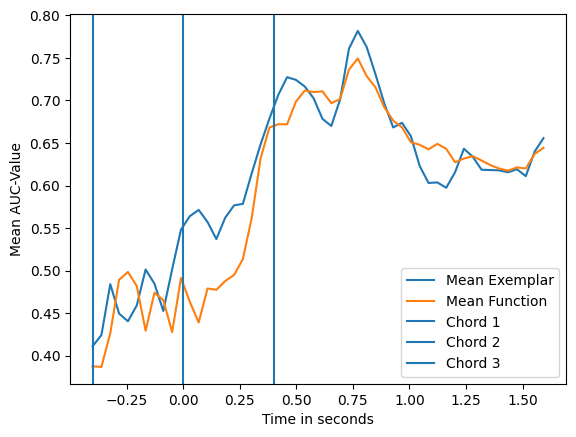

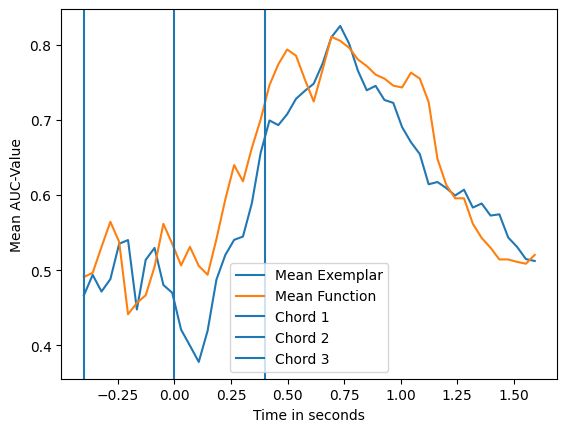

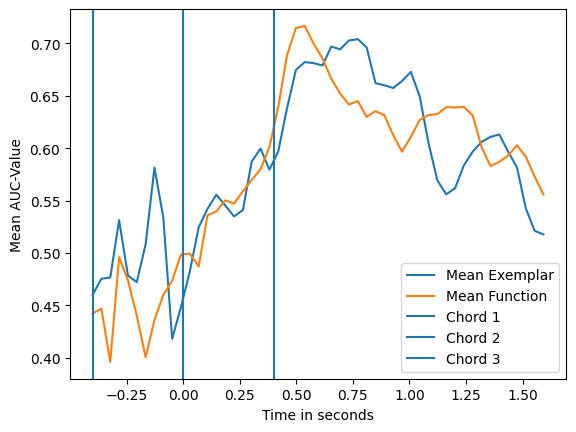

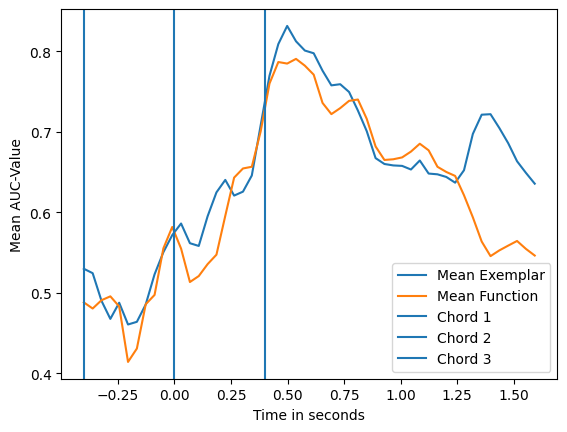

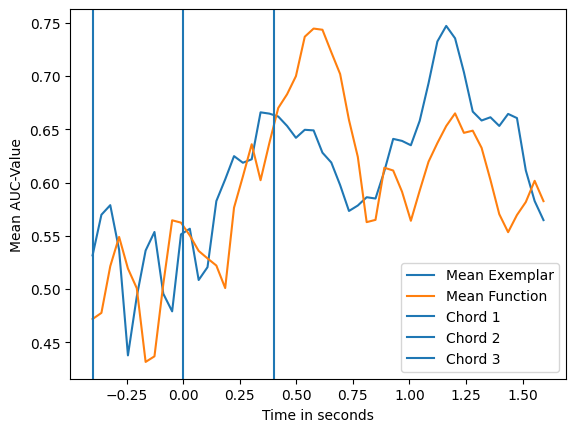

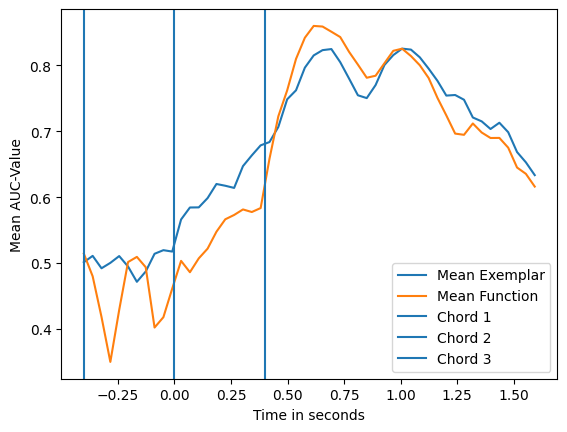

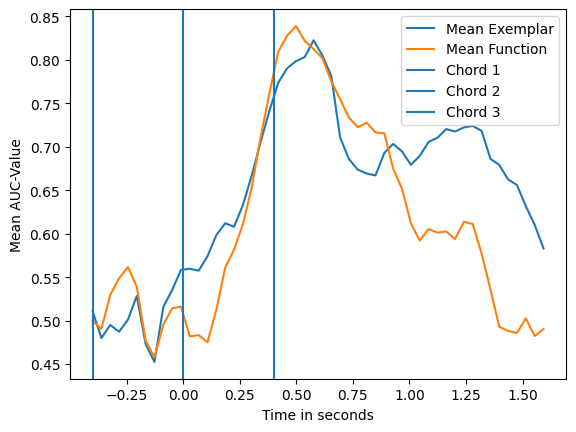

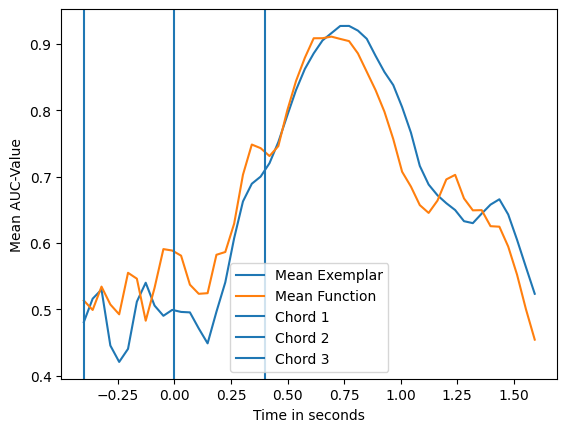

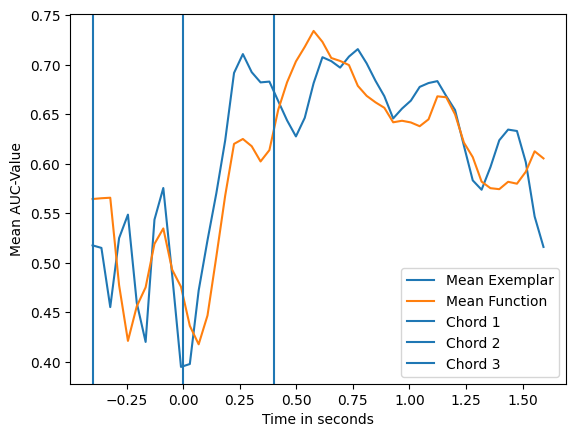

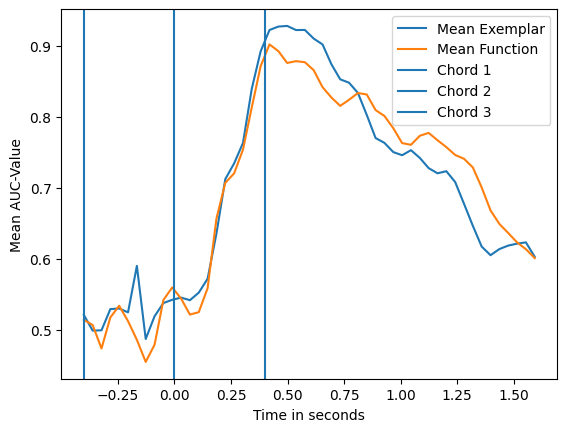

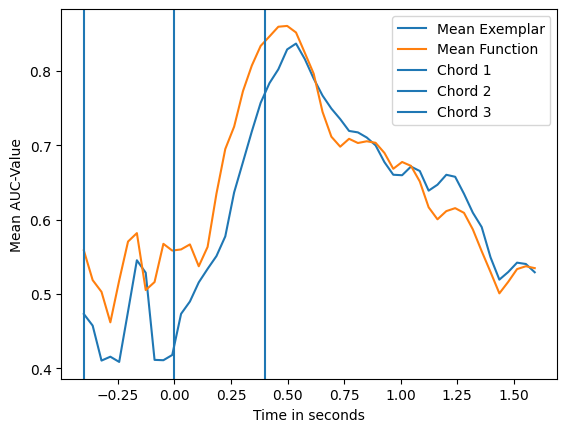

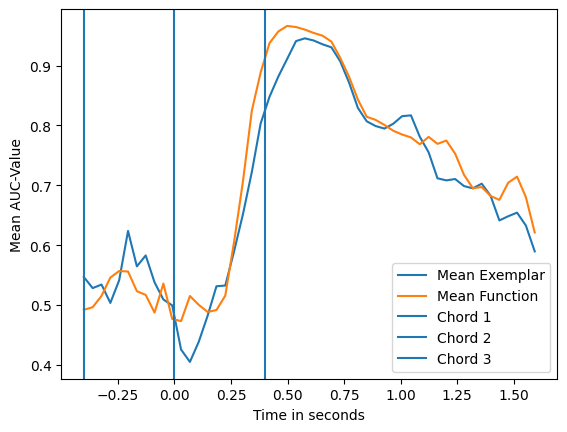

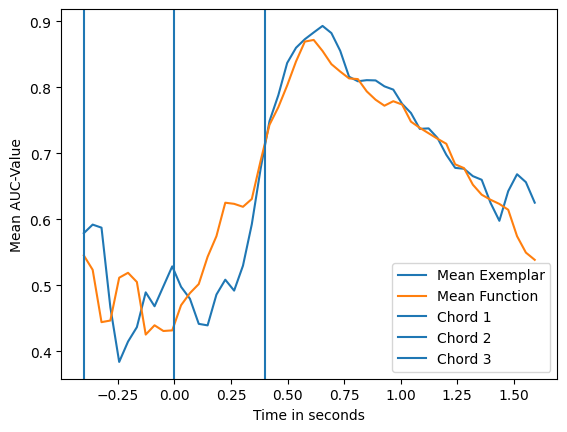

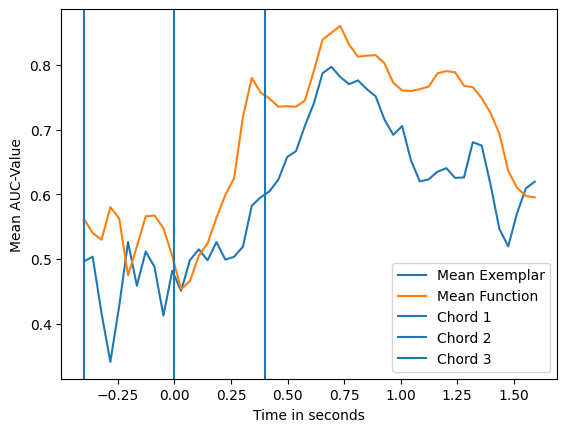

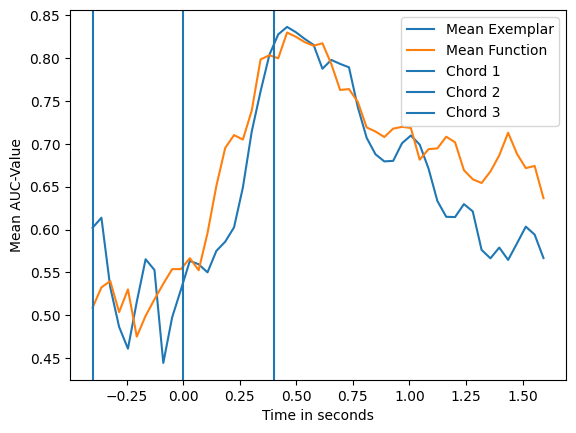

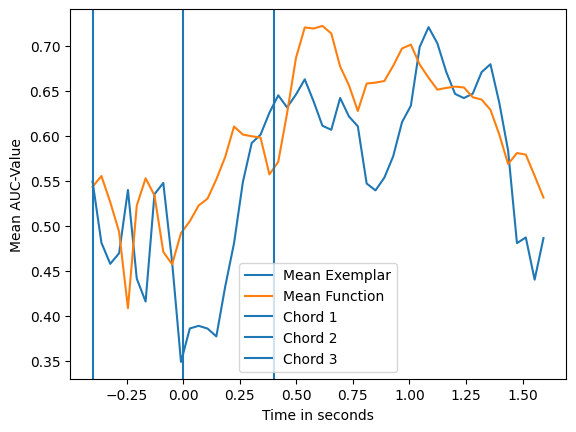

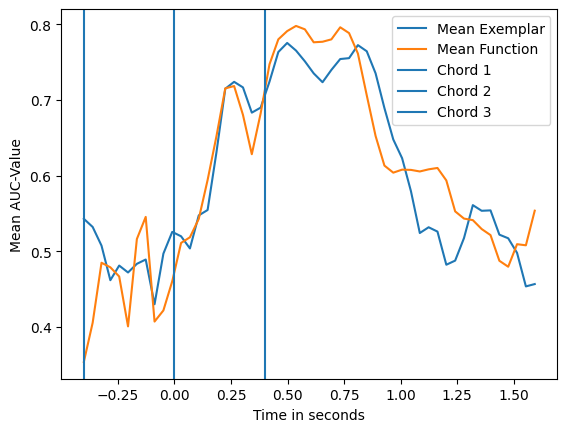

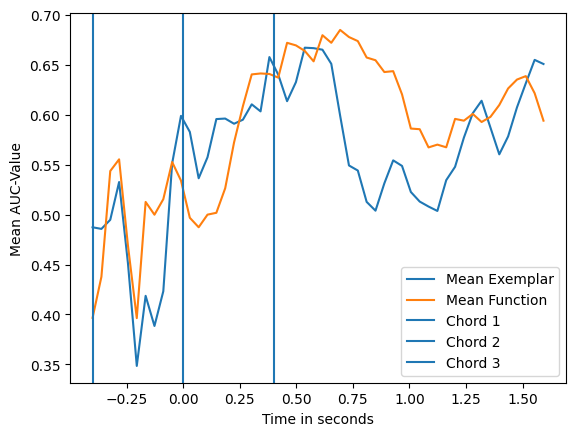

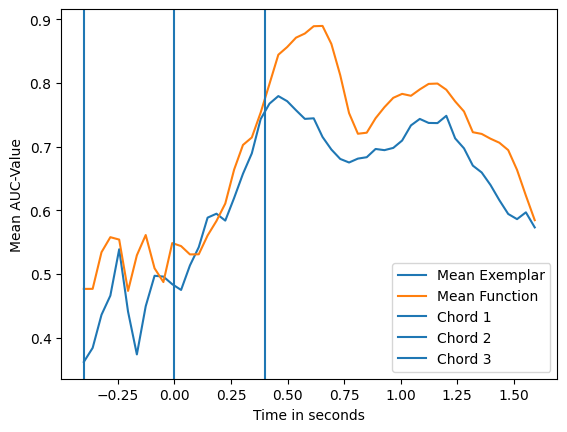

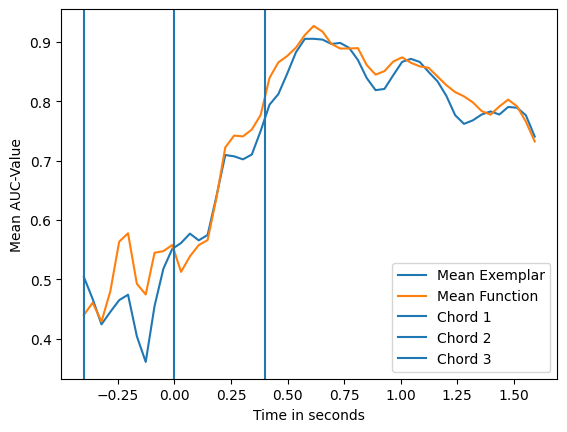

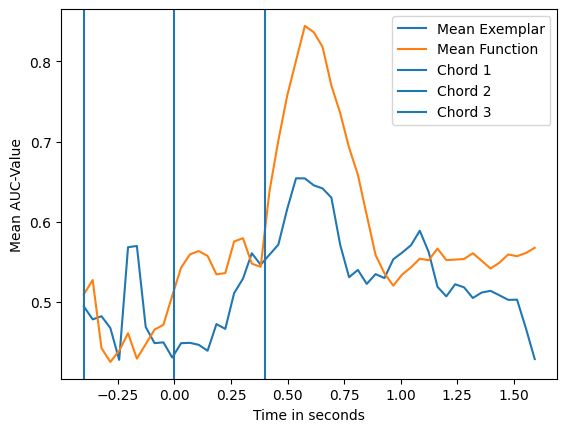

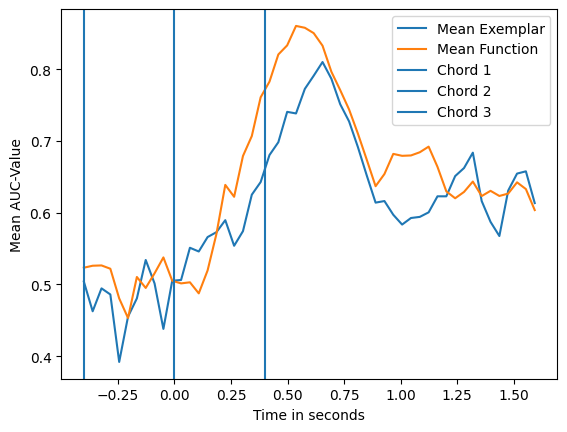

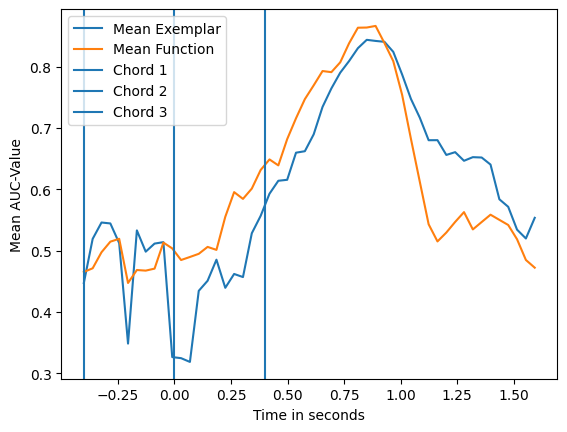

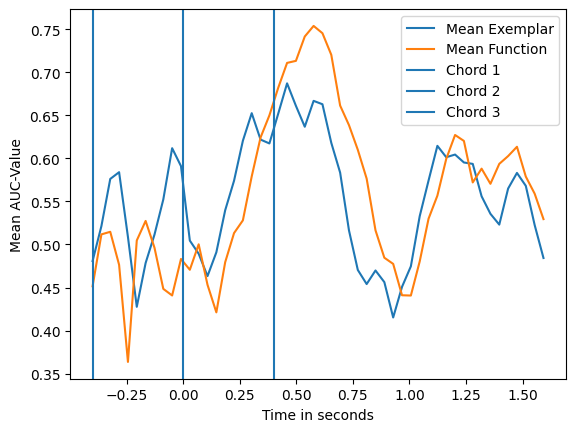

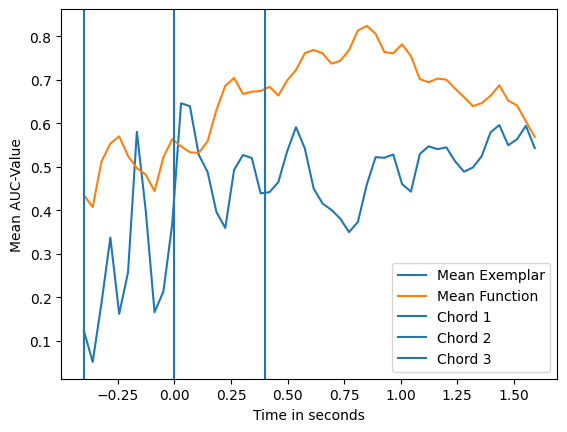

In [17]:
# Step and window size used for generating data
step = 5
window = 13

# Directory where the files are stored
data_dir = "./data"
file_paths = find_txt_files(data_dir)


# Process each file
for file_name in file_paths:
    file_path = data_dir + "/" + file_name
    if os.path.exists(file_path):
        # Read the data from the file
        data = np.loadtxt(file_path)
        

        # Generate the time vector
        time = [i * step / 128 - 0.4 for i in range(len(data[:, 0]))]

        # Plotting
        plt.plot(time, data[:, 0], label="Mean Exemplar")
        plt.plot(time, data[:, 1], label="Mean Function")

        plt.axvline(-0.4, label="Chord 1")
        plt.axvline(0, label="Chord 2")
        plt.axvline(0.4, label="Chord 3")
        plt.ylabel("Mean AUC-Value")
        plt.xlabel("Time in seconds")
        plt.legend()
        plt.show()